# Multivariante Kalman Filter
In general, the Kalman filter can be represented in the following matrix form: ($\boldsymbol{R}$ is the measurement covariance matrix)

Predict
Predicted state estimate	

\begin{equation}{\hat{\boldsymbol {x}}}_{k|k-1}=f({\hat {\boldsymbol {x}}}_{k-1|k-1},{\boldsymbol {u}}_{k-1})
\end{equation}
Predicted covariance estimate	

\begin{equation} \boldsymbol {P}_{k|k-1}={{\boldsymbol {F}}_{k}}{\boldsymbol {P}}_{k-1|k-1}{{\boldsymbol {F}}_{k}^{T}}+{\boldsymbol {Q}}_{k-1} 
\end{equation}

Update
Innovation or measurement residual	
\begin{equation}
  \tilde{\boldsymbol{y}}_{k}=\boldsymbol{z}_{k} - h({\hat{{\boldsymbol{x}}}}_{{k|k-1}}) \end{equation}
  
Near-optimal Kalman gain
\begin{equation}
\boldsymbol {K}_{k}=\boldsymbol{P}_{k|k-1} \boldsymbol {H}_{k}^{T} \Big(\boldsymbol{H}\boldsymbol{P}\boldsymbol{H}^T + \boldsymbol{R}\Big)^{-1}
\end{equation}

Updated state estimate	
\begin{equation}
\hat{\boldsymbol{x}_{k|k}}=\hat{\boldsymbol{x}}_{k|k-1} + \boldsymbol{K}_{k} \tilde{\boldsymbol{y}}_{k}
\end{equation}

Updated covariance estimate	
\begin{equation} \boldsymbol{P}_{k|k}=( \boldsymbol{I}- \boldsymbol{K}_{k} \boldsymbol{H}_{k})\boldsymbol{P}_{k|k-1}
\end{equation}

where $\boldsymbol{F}$ and $\boldsymbol{H}$ are the Jacobian matrix for $f$ and $h$

# Construction of state transition model

Consider the simplest example, where we are trying to construct the state transition model of a moving aircraft travelling at constant velocity. We can easily write down the 1st order ODE
\begin{align}
\dot{x}_n &= v
\end{align}

To convert the linear ODE into a state transition model, we perform integration to the above equation. For discrete case, we perform forward Euler discretization to the equation. 
\begin{align}
\frac{x_n - x_{n-1}}{\Delta t} &= v \\
x_n &= x_{n-1} + v\Delta t\\
\dot{x}_n &= \dot{x}_{n-1} \\
\end{align}

If we only want to estimate the position, we can use $x_n = x_{n-1} + v\Delta t$ as the state transition matrix in the 1D Kalman filter, and our job is done. If the initial velocity is also unknown to us, we can infer the velocity using the same method by making the velocity as one of the state variables. Rewrite the transition equation into matrix form and we obtained:
\begin{align}
\boldsymbol{x}_n = \begin{bmatrix}x_n \\ \dot{x}_n \end{bmatrix} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{n-1} \\ \dot{x}_{n-1} \end{bmatrix} = \boldsymbol{F}\boldsymbol{x}_{n-1}
\end{align}


Text(0, 0.5, 'velocity')

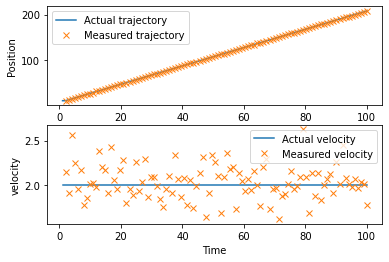

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data(x0, v0, count, noise = 0, accel=0.):
    #generate data given the initial state, velocity, acceleration and noise 
    xs = [x0]
    vs = [v0]
    zs1 = []
    zs2 = []
    for i in range(count):
        xs.append(x0 + accel * (i**2) / 2 + v0*i)
        zs1.append(x0 + accel * (i**2) / 2 + v0*i + noise*np.random.randn())
        vs.append(v0 + accel)
        zs2.append(v0 + accel + noise*np.random.randn())
    zs = np.array([zs1, 
                  zs2], dtype='float')
    true = np.array([xs,
                     vs], dtype='float')
    return true, zs

x0 = 10
v0 = 2
count = 100
dt = 1
var = 0.2
time = np.linspace(1, count, count+1)
xs, zs = gen_data(x0, v0, count, noise = var)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, xs[0], '-', label = 'Actual trajectory')
ax1.plot(time[1:], zs[0], 'x', label = 'Measured trajectory')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')

ax2.plot(time, xs[1], '-', label = 'Actual velocity')
ax2.plot(time[1:], zs[1], 'x', label = 'Measured velocity')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('velocity')

mean p 2.06, variance of p 0.15


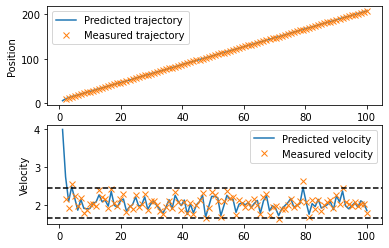

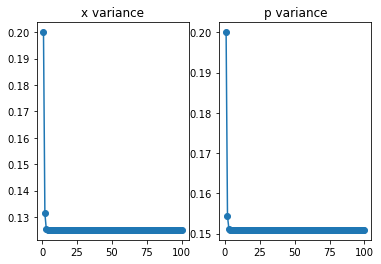

In [2]:
from numpy.linalg import inv
import math
def predict(x, P, Q):  
    dt = 1
    F = np.array([[1, dt],
                  [0, 1],
                 ], dtype='float') 
    
    #predict covariance
    P = F @ P @ F.T + Q
    
    x = F @ x
    return x, P

def update(x, P, H, R, z):
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S) #kalman gain
    y = z - H @ x #innovation 
    x += K @ y   #update state based on prior
    P = P - K @ H @ P #update covariance based on prior
    return x, P, K

def EKF(x, P, Q, H, R, z):
    x_list, P_list, K_list =  [x[:,0]], [P], []
    for item in range(z.shape[1]):
        x, P = predict(x, P, Q)
        #transform z into a column vector
        z_t = z[:, item].reshape([z.shape[0],1])
        x, P, K = update(x, P, H, R, z_t)
        x_list.append(x[:,0])
        P_list.append(P)
        K_list.append(K)
    return x_list, P_list, K_list

Q = np.array([[(dt**3)/3, (dt**2)/2],
                          [(dt**2)/2, dt]
                          ],  dtype='float') #process noise

H = np.array([[1, 0],
              [0, 1]], dtype = 'float')

R = var*np.array([[1,0],
              [0, 1]], dtype='float')

P = var*np.array([[1,0],
              [0,1]], dtype ='float') #variance initial guess 

x = np.array([[5],
             [4]]) #state space initial guess

x_list, P_list, K_list = EKF(x,P,Q, H,R,zs)
#print(x_list)
x_arr = np.array(x_list)
P_arr = np.array(P_list)
#K_arr = np.array(K_list)
#print(P_arr)
#print(P_arr[:,0,0])
fig2, (ax3, ax4) = plt.subplots(2)
ax3.plot(time, x_arr[:,0], '-', label = 'Predicted trajectory')
ax3.plot(time[1:], zs[0], 'x', label = 'Measured trajectory')
ax3.legend()
ax3.set_ylabel('Position')
ax4.plot(time, x_arr[:,1], '-', label = 'Predicted velocity')
ax4.plot(time[1:], zs[1], 'x', label = 'Measured velocity')
ax4.legend()
ax4.set_ylabel('Velocity')

fig3, (ax_covx, ax_covp) = plt.subplots(1,2)
ax_covx.plot(time, P_arr[:,0,0], '-o', label = 'x Variance')
ax_covp.plot(time, P_arr[:,1,1], '-o', label = 'p variance')
ax_covx.set_title('x variance')
ax_covp.set_title('p variance')

#print out the velocity variance 
v_mean = np.mean(x_arr[:,1])
print('mean p {}, variance of p {}'.format(round(v_mean,2), round(P_arr[-1,1,1],2)))

ax4.axhline(y= v_mean + math.sqrt(P_arr[-1,1,1]), ls = '--', color = 'k')
ax4.axhline(y= v_mean - math.sqrt(P_arr[-1,1,1]), ls = '--', color = 'k')



The velocity prediction looks very jagged, which is due to the large process noise, and may be troubling for us since we know the velocity should be constant. This is because we tell the filter to trust less of the model, and more of the measurement, thus it always follows the measurement. But if we plot the velocity variance and the error bar in the plot, you will see that the prediction is actually within the error. In fact, the mean velocity obtained from the Kalman filter is very close to the initial velocity. This is encouraging, and leaves room to perform parameter inference, which we shall discuss in the future. We can make the velocity prediction less jagged by tuning the process noise. 

Text(0, 0.5, 'Velocity')

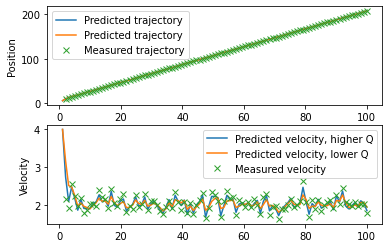

In [3]:
Q = np.array([[0.00033, 0.005],
             [0.005, 0.1]],  dtype='float') #process noise

x_list2, P_list2, K_list2 = EKF(x,P,Q,H,R,zs)
#print(x_list)
x_arr2 = np.array(x_list2)
P_arr2 = np.array(P_list2)
#K_arr = np.array(K_list2)
#print(P_arr)
#print(P_arr[:,0,0])
fig4, (ax5, ax6) = plt.subplots(2)
ax5.plot(time, x_arr[:,0], '-', label = 'Predicted trajectory')
ax5.plot(time, x_arr2[:,0], '-', label = 'Predicted trajectory')
ax5.plot(time[1:], zs[0], 'x', label = 'Measured trajectory')
ax5.legend()
ax5.set_ylabel('Position')
ax6.plot(time, x_arr[:,1], '-', label = 'Predicted velocity, higher Q')
ax6.plot(time, x_arr2[:,1], '-', label = 'Predicted velocity, lower Q')
ax6.plot(time[1:], zs[1], 'x', label = 'Measured velocity')
ax6.legend()
ax6.set_ylabel('Velocity')

In [ ]:
Q = np.array([[(dt**3)/3, (dt**2)/2, 0 ],
                          [(dt**2)/2, dt, 0],
              [0, 0 , 0]],  dtype='float') #process noise

H = np.array([[1, 0],
              [0, 1]], dtype = 'float')

R = var*np.array([[1,0],
              [0, 1]], dtype='float')

P = var*np.array([[1,0],
              [0,1]], dtype ='float') #variance initial guess 

x = np.array([[5],
             [4]]) #state space initial guess

x_list, P_list, K_list = EKF(x,P,Q, H,R,zs)

# Case 3, Pendulum

Consider the pendulum case, where $\ddot{\theta}(t) = -\frac{g}{l}\sin{\theta}$ .
\begin{align}
\dot{\boldsymbol{x}} = \begin{bmatrix}\dot{x_1} \\ \dot{x_2} \end{bmatrix} = \begin{bmatrix} x_2 \\ -\frac{g}{l\sin{x_1}} \end{bmatrix} = \boldsymbol{\beta}(x)
\end{align}

Perform Forward Euler discretization on the ODE
\begin{align}
\frac{\boldsymbol{x}_n -\boldsymbol{x}_{n-1}}{\Delta t} &\approx \boldsymbol{\beta}(x_{n-1}) \\
\boldsymbol{x}_n \approx \boldsymbol{x}_{n-1} + \Delta t \boldsymbol{\beta}(x_{n-1})
\end{align}


# Case 4: Prey Predator Model
Consider the prey predator model. Let $x_1$ be the prey population, and $x_2$ be the predator population. The 1st order ODE that describes this model is given by

\begin{equation}
\begin{bmatrix} \dot{x_1} \\ \dot{x_2} \end{bmatrix} = \begin{bmatrix} kx_1 - ax_1x_2 \\ -rx_2 + bx_1x_2  \end{bmatrix}
\end{equation}

We want to infer the parameter of the rate too. Therefore, we make the rate as a state variable
\begin{equation}
\begin{bmatrix} \dot{x_1} \\ \dot{x_2} \\ \dot{k} \\ \dot{a} \\ \dot{r} \\ \dot{b} \end{bmatrix} = \begin{bmatrix} kx_1 - ax_1x_2 \\ -rx_2 + bx_1x_2  \\ 0 \\ 0 \\ 0 \\0 \end{bmatrix}
\end{equation}

To linearize the non-linear equation above, we first calculate the Jacobian matrix of the transition matrix. 
\begin{align}
\boldsymbol{J} = \begin{bmatrix} 
k-ax_2 & -ax_1 & x_1 & -x_1x_2 & 0 & 0 \\
bx_2 & bx_1-r & 0 & 0 & -x_2 & x_1x_2 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
\end{align}

Then, the linearize equation becomes:
\begin{align}
\boldsymbol{x}(n) = \begin{bmatrix} x_1(n-1) \\ x_2(n-1) \\ k(n-1) \\ a(n-1) \\ r(n-1) \\ b(n-1)\end{bmatrix} + \Delta t \begin{bmatrix} 2kx_1(n-1)- 3ax_1(n-1)x_2(n-1) \\ 3bx_1(n-1)x_2(n-1) -2rx_2(n-1) \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}
\end{align}

The dimension of the measurable space and the state space is different, the measurables are the population number $x_1$ and $x_2$, i.e. $\boldsymbol{z} = \begin{bmatrix}x_1 \\ x_2\end{bmatrix}$. We need to transform the state space to the measurable space. For this particular system, the measurables are the populations $x_1$ and $x_2$. The transformation from the state space to the measurable space can then be approximated as 
\begin{align}
 x_1(n+1) &\approx x_1(n) + \Delta t (2kx_1(n)- 3ax_1(n)x_2(n)) \\
 x_2(n+1) &\approx x_2(n) + \Delta t (3bx_1(n)x_2(n) -2rx_2(n))
\end{align}

Let $\boldsymbol{H}$ be the measurement matrix, the measurement matrix is
\begin{equation}
\boldsymbol{H}_n = \begin{bmatrix} 2k\Delta t + 1 - 3x_2 a \Delta t & -3ax_1 \Delta t & 2x_1\Delta t & -3x_1x_2\Delta t & 0 & 0 \\ 3x_2b\Delta t & 1 + 3x_1b\Delta t - 2r\Delta t & 0 & 0 & -2x_2\Delta t & 3x_1x_2\Delta t  \end{bmatrix}
\end{equation}

The residual function is therefore
\begin{equation}
\boldsymbol{y}_n = \boldsymbol{z}_n + \boldsymbol{H}\boldsymbol{x}_n 
\end{equation}

Lets try to implement the extended Kalman filter to infer the parameters. We first generate the population data with noise:

Text(0, 0.5, 'Population')

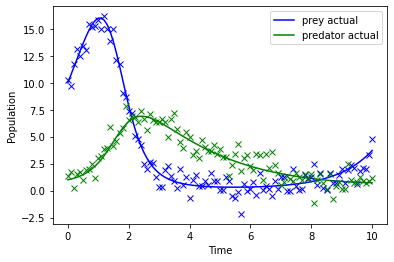

In [4]:
from scipy.integrate import odeint
from numpy.random import randn
import math

def func(x, t, k, a, b, r):
    dx1dt = k*x[0] - a*x[0]*x[1]
    dx2dt = -r*x[1] + b*x[0]*x[1]
    return [dx1dt, dx2dt]

def generate_data(sol, var, count):
    z1_std = math.sqrt(var[0])
    z2_std = math.sqrt(var[1])
    z1, z2 = [], []
    for x in range(count):
        z1.append(sol[x,0] + randn() * z1_std)
        z2.append(sol[x,1] + randn() * z2_std)
    return z1, z2

k = 1.1
a = 0.4
b = 0.1
r = 0.4

x0 = [10, 1]
count = 101
t = np.linspace(0, 10, count)
dt = t[1] - t[0] #time increment
sol = odeint(func, x0, t, args = (k,a,b,r))

plt.plot(t, sol[:, 0], 'b', label='prey actual')
plt.plot(t, sol[:, 1], 'g', label='predator actual')
plt.legend()

var = [0.5, 0.5]
z1, z2 = generate_data(sol, var, count)
plt.plot(t, z1, 'bx', label='prey measured')
plt.plot(t, z2, 'gx', label='predator measured')
plt.xlabel('Time')
plt.ylabel('Population')

Next, we compute the fundamental matrix $\boldsymbol{F}$ and predict the evolution of the system. We assumed the process noise to be assumed to be drawn from a zero mean multivariate normal distribution, assumed to be drawn from a zero mean multivariate normal distribution with covariance, Qk: 

In [5]:
from numpy.linalg import inv

z = np.array([[z1],
            [z2]
            ])

x0 = np.array([[11],
              [2],
              [1.2],
              [1],
              [1],
              [1]
              ]) # initial prediction


process_var = 0.1
Q = process_var*np.array([[(dt**3)/3, (dt**2)/2, 0, 0, 0, 0],
                          [(dt**2)/2, dt, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0],
                          ]) #process noise

P0 = np.array([[10, 0, 0, 0, 0, 0],
               [ 0, 10, 0, 0, 0, 0],
               [ 0, 0, 10, 0, 0, 0],
               [ 0, 0, 0, 10, 0, 0],
               [ 0, 0, 0, 0, 10, 0],
               [ 0, 0, 0, 0, 0, 10],
              ])

H = np.array([[1, 0, 0, 0, 0, 0],
             [0, 1, 0, 0, 0, 0]]) #

measurement_var1 = 0.5
measurement_var2 = 0.5

R = np.array([[measurement_var1, 0],
             [0, measurement_var2]]) #measurement variance matrix

def predict2(x, P, Q):
    #compute jacobian
    F00 = x[2] - x[1] * x[3]
    F01 = -1*x[0] * x[3]
    F02 = x[0]
    F03 = -1*x[0]*x[1]
    F10 = x[1]*x[5]
    F11 = x[0]*x[5] - x[4]
    F14 = -1*x[1]
    F15 = x[0]*x[1]
    
    F = np.array([[F00, F01, F02, F03, 0, 0],
                  [F10, F11, 0, 0, F14, F15],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                 ]) 
    
    #predict covariance
    P = F @ P @ F.t + Q
    
    x = F @ x
    return x, P

def update2(x, P, H, R):
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S) #kalman gain
    y = z - H @ x #innovation 
    x += K @ y   #update state based on prior
    P = P - K @ H @ P #update covariance based on prior
    return x, P, K

def EKF2(x0, P0, Q, H, R, z):
    x_arr, K_arr =  [x0], []
    
    for item in range(z.shape[0]):
        x, P = predict2(x0, P0, Q)
        x, P, K = update2(x, P, H, R)
        x_arr.append(x)
        K_arr.append(K)
    return x_arr, K_arr

x_arr, K_arr = EKF2(x0, P0, Q, H, R, z)

<ipython-input-5-8c70c9a3fdad>:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  F = np.array([[F00, F01, F02, F03, 0, 0],


AttributeError: 'numpy.ndarray' object has no attribute 't'

In [ ]:
def EKF():
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)